In [3]:
import pickle
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cross_validation import train_test_split
from sklearn.linear_model import LogisticRegressionCV

from keras.layers import LSTM
from keras.layers import Embedding
from keras.optimizers import RMSprop


from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.utils import np_utils

from sklearn.metrics import accuracy_score


import keras
from keras.utils import to_categorical

from matplotlib import pyplot as plt
from IPython.display import clear_output

/usr/local/lib/python3.5/dist-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
Using TensorFlow backend.


In [12]:
y = np.load("y.npy")
X = np.load("X.npy")

In [21]:
els, counts = np.unique(y, return_counts=True)
#plt.scatter(range(len(els)), counts)
#plt.show()
#print(els, counts)
rare = els[counts < 10]

isin = np.logical_not(np.isin(y, rare))
print(X.shape)
X = X[isin, :]
print(X.shape)
y = y[isin]

els, counts = np.unique(y, return_counts=True)
#plt.scatter(range(len(els)), counts)
#plt.show()
print(els)
print(len(els))


feat = X.shape[1]
print("Features:", feat)
tst = np.array([1])
print(tst.dtype, X.dtype)
if X.dtype == tst.dtype:
    num_features = np.zeros(feat, dtype='bool')
else:
    num_features = np.array(['0' <= X[0, i][0] <= '9' for i in range(feat)])
cat_features = np.logical_not(num_features)


#X_cat = X[:,8:16]
#X_real = np.int_(np.hstack([X[:,:8], X[:,16:]]))

X_cat = X[:,cat_features]
X_real = np.int_(X[:,num_features])
print(X_cat[0,:])
print(X_real[0,:])
from sklearn.preprocessing import LabelEncoder

enc = LabelEncoder()
enc.fit(X_cat.reshape(X_cat.size))
for i in range(sum(cat_features)):
    X_cat[:, i] = enc.transform(X_cat[:, i])

X = np.hstack([np.int_(X_cat), X_real])

(10174, 56)
(10174, 56)
['a' 'am' 'b' 'bb' 'bm' 'c' 'cm' 'd' 'dm' 'e' 'eb' 'em' 'f' 'f#' 'f#m' 'g'
 'gm']
17
Features: 56
int64 int64
[5 5 5 5 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 7 7 7 7 5 5 5 5 2 2 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1]
[]


In [43]:
chords = ['a', 'am', 'b', 'bb', 'bm', 'c', 'cm', 'd', 'dm', 'e', 'eb', 'em', 'f', 'f#', 'f#m', 'g', 'gm']

In [84]:
coded_y = []

for y_chord in y:
    for i, chord in enumerate(chords):
        if y_chord == chord:
            coded_y.append(i)


In [47]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, coded_y)

In [48]:
class PlotLearning(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        self.acc = []
        self.val_acc = []
        self.fig = plt.figure()
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.acc.append(logs.get('acc'))
        self.val_acc.append(logs.get('val_acc'))
        self.i += 1
        f, (ax1, ax2) = plt.subplots(1, 2, sharex=True)
        
        clear_output(wait=True)
        
        ax1.set_yscale('log')
        ax1.plot(self.x, self.losses, label="loss")
        ax1.plot(self.x, self.val_losses, label="val_loss")
        ax1.legend()
        
        ax2.plot(self.x, self.acc, label="accuracy")
        ax2.plot(self.x, self.val_acc, label="validation accuracy")
        ax2.legend()
        
        plt.show();
        
plot = PlotLearning()

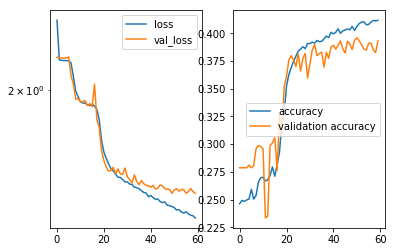

In [64]:
model = Sequential()
model.add(Embedding(18, 20, input_length=56))
model.add(LSTM(20))
model.add(Dense(17, activation='softmax'))
model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])
model.fit(X_train, y_train, epochs=60, verbose=1, validation_data=(X_test, y_test), callbacks=[plot]);

In [83]:
y_pred = model.predict(X_test).argmax(axis=1)

print(accuracy_score(y_test, y_pred)) 

0.39308176100628933
